# <a id='toc1_'></a>[Descripción del proyecto](#toc0_)
Estás trabajando como analista para Zuber, una nueva empresa de viajes compartidos que se está lanzando en Chicago. Tu tarea es encontrar patrones en la información disponible. Quieres comprender las preferencias de los pasajeros y el impacto de los factores externos en los viajes.

Al trabajar con una base de datos, analizarás los datos de los competidores y probarás una hipótesis sobre el impacto del clima en la frecuencia de los viajes.

La parte preliminar de éste proyecto consiste en obtener las tablas con las que se va a trabajar mediante peticiones con PostgreSQL. Para eso, se utiliza el siguiente comando:

In [ ]:
'''
SELECT
    trips.start_ts,
    CASE
        WHEN (weather_records.description LIKE '%rain%' OR weather_records.description LIKE '%storm%') THEN
            'Bad'
        ELSE 'Good' END weather_conditions,
    trips.duration_seconds
FROM
    trips
    INNER JOIN weather_records on trips.start_ts = weather_records.ts
WHERE
    trips.pickup_location_id = 50
    AND
    trips.dropoff_location_id = 63
    AND
    EXTRACT(DOW from trips.start_ts) = 6
ORDER BY
    trips.trip_id
'''

**Table of contents**<a id='toc0_'></a>    
- [Descripción del proyecto](#toc1_)    
- [Inicialización](#toc2_)    
- [Carga de datos](#toc3_)    
- [Exploracion inicial de datos](#toc4_)    
- [Correcciones iniciales de datos](#toc5_)    
- [Analisis Exploratorio de Datos](#toc6_)    
- [Prueba de hipótesis](#toc7_)    
- [Conclusión](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Inicialización](#toc0_)
Primero vamos a cargar las librerias con las que vamos a trabajar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import re

# <a id='toc3_'></a>[Carga de datos](#toc0_)
Ahora cargamos los datasets en sus respectivas variables.

In [2]:
company_trips = pd.read_csv('../../data/raw/project_sql_result_01.csv')
neighborhood_trips = pd.read_csv('../../data/raw/project_sql_result_04.csv')

# <a id='toc4_'></a>[Exploracion inicial de datos](#toc0_)
Ahora vamos a ir tabla por tabla explorando sus datos, corrigiendo algún tipo de error que tengan y de ser posible tratando de enriquecer sus tablas con una columna que nos sea de mayor utilidad.

In [3]:
# Usamos info para ver detalles basicos y no usamos head ya que quiero observar las ultimas filas tambien
company_trips.info()
company_trips

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
...,...,...
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,2241 - 44667 - Felman Corp,3


De lo que podemos observar las columnas son:
- company_name: nombre de la empresa de taxis.
- trips_amount: el número de viajes de cada compañía de taxis el 15 y 16 de noviembre de 2017.
  
No parecen tener celdas con valores ausentes, lo que es bueno, y tambien vemos que los *dtypes* son coherentes con lo que las columnas representan. Tambien vemos como el df viene ya ordenado de forma descendente respecto a `trips_amount`.
  
Ahora vamos a observar el otro dataframe!

In [4]:
# Haremos lo mismo que antes
neighborhood_trips.info()
neighborhood_trips

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
...,...,...
89,Mount Greenwood,3.137931
90,Hegewisch,3.117647
91,Burnside,2.333333
92,East Side,1.961538


Podemos ver una situacion muy similar al dataframe anterior, por suerte. No vemos ningun dato faltante y los *dtypes* son correspondientes tambien, ahora veamos que significa cada columna.
  
- dropoff_location_name: barrios de Chicago donde finalizaron los viajes
- average_trips: el promedio de viajes que terminaron en cada barrio en noviembre de 2017.

# <a id='toc5_'></a>[Correcciones iniciales de datos](#toc0_)
Ahora vamos a analizar cuestiones basicas de los datos sin ahondar demasiado.

In [5]:
# Primero vemos company_trips
company_trips.duplicated().sum()

0

In [6]:
# Y ahora neighborhood_trips
neighborhood_trips.duplicated().sum()

0

Estas son muy buenas noticias! Sin ningun duplicado, veamos en mas detalle cuales son los valores que poblan las columnas *object* de nuestras tablas.

In [7]:
# De vuelta, primero company_trips
company_trips['company_name'].unique()

array(['Flash Cab', 'Taxi Affiliation Services', 'Medallion Leasing',
       'Yellow Cab', 'Taxi Affiliation Service Yellow',
       'Chicago Carriage Cab Corp', 'City Service', 'Sun Taxi',
       'Star North Management LLC', 'Blue Ribbon Taxi Association Inc.',
       'Choice Taxi Association', 'Globe Taxi',
       'Dispatch Taxi Affiliation', 'Nova Taxi Affiliation Llc',
       'Patriot Taxi Dba Peace Taxi Association',
       'Checker Taxi Affiliation', 'Blue Diamond',
       'Chicago Medallion Management', '24 Seven Taxi',
       'Chicago Medallion Leasing INC', 'Checker Taxi', 'American United',
       'Chicago Independents', 'KOAM Taxi Association', 'Chicago Taxicab',
       'Top Cab Affiliation', 'Gold Coast Taxi',
       'Service Taxi Association', '5 Star Taxi', '303 Taxi',
       'Setare Inc', 'American United Taxi Affiliation', 'Leonard Cab Co',
       'Metro Jet Taxi A', 'Norshore Cab', '6742 - 83735 Tasha Ride Inc',
       '3591 - 63480 Chuks Cab', '1469 - 64126 Omar Jada'

Al parecer tenemos muchas companias que tienen un grupo de numeros con guion... honestamente no se bien que representaran y posiblemente sean importantes. Pero para nuestro analisis solo complican la visualizacion. Por lo tanto, vamos a hacer uso de una regex para eliminar esos numeros, guiones y espacios y quedarnos solo con los textos.

In [8]:
# Primero hacemos una prueba en la fila 59 que sabemos que tiene ese detalle
re.sub(r'\d* - \d*[ -]*','',company_trips.loc[59,'company_name'])

'Adwar H. Nikola'

In [9]:
# Definimos una pequeña funcion

def numbers_replace(row):
    new_string = re.sub(r'\d* - \d*[ -]*','',row['company_name'])
    return new_string

In [10]:
# Ahora probamos usando apply
company_trips.apply(numbers_replace,axis = 1)

0                           Flash Cab
1           Taxi Affiliation Services
2                   Medallion Leasing
3                          Yellow Cab
4     Taxi Affiliation Service Yellow
                   ...               
59                    Adwar H. Nikola
60                         Benny Jona
61                   Sergey Cab Corp.
62                        Felman Corp
63                     RC Andrews Cab
Length: 64, dtype: object

In [11]:
# Con la funcion actuando de manera acorde vamos a reemplazar la columna
company_trips['company_name'] = company_trips.apply(numbers_replace,axis = 1)

In [12]:
company_trips['company_name'].unique()

array(['Flash Cab', 'Taxi Affiliation Services', 'Medallion Leasing',
       'Yellow Cab', 'Taxi Affiliation Service Yellow',
       'Chicago Carriage Cab Corp', 'City Service', 'Sun Taxi',
       'Star North Management LLC', 'Blue Ribbon Taxi Association Inc.',
       'Choice Taxi Association', 'Globe Taxi',
       'Dispatch Taxi Affiliation', 'Nova Taxi Affiliation Llc',
       'Patriot Taxi Dba Peace Taxi Association',
       'Checker Taxi Affiliation', 'Blue Diamond',
       'Chicago Medallion Management', '24 Seven Taxi',
       'Chicago Medallion Leasing INC', 'Checker Taxi', 'American United',
       'Chicago Independents', 'KOAM Taxi Association', 'Chicago Taxicab',
       'Top Cab Affiliation', 'Gold Coast Taxi',
       'Service Taxi Association', '5 Star Taxi', '303 Taxi',
       'Setare Inc', 'American United Taxi Affiliation', 'Leonard Cab Co',
       'Metro Jet Taxi A', 'Norshore Cab', 'Tasha Ride Inc', 'Chuks Cab',
       'Omar Jada', 'Luhak Corp', 'Godfrey S. Awir',
    

Mucho mejor, ahora pasemos a observar la otra tabla y ver si tiene comportamientos similares.

In [13]:
# Veamos los diferentes barrios en la tabla
neighborhood_trips['dropoff_location_name'].unique()

array(['Loop', 'River North', 'Streeterville', 'West Loop', "O'Hare",
       'Lake View', 'Grant Park', 'Museum Campus', 'Gold Coast',
       'Sheffield & DePaul', 'Lincoln Park', 'East Village',
       'Little Italy, UIC', 'Uptown', 'Near South Side', 'Garfield Ridge',
       'Logan Square', 'Edgewater', 'West Town', 'Old Town',
       'Rush & Division', 'North Center', 'Lincoln Square', 'Rogers Park',
       'West Ridge', 'Irving Park', 'Hyde Park', 'Avondale',
       'Wicker Park', 'Albany Park', 'United Center', 'Lower West Side',
       'Douglas', 'Portage Park', 'Humboldt Park', 'Norwood Park',
       'Kenwood', 'Bridgeport', 'Armour Square', 'Jefferson Park',
       'Bucktown', 'North Park', 'Garfield Park', 'Mckinley Park',
       'Belmont Cragin', 'Boystown', 'Chinatown', 'Grand Boulevard',
       'Austin', 'Sauganash,Forest Glen', 'South Shore', 'Woodlawn',
       'Little Village', 'Jackson Park', 'North Lawndale', 'Dunning',
       'Ukrainian Village', 'Hermosa', 'Englewood'

Todo parece en orden por aca, asi que con lo básico fuera de la mesa podemos proceder a realizar unos análisis un poco más profundos.

# <a id='toc6_'></a>[Analisis Exploratorio de Datos](#toc0_)
Para esta parte vamos a observar las metricas de ambas tablas y ver cuales son los barrios y empresas que se ubican en el top 10.

In [14]:
# Primero veamos como se distribuyen en company_trips, hacemos un reset_index para que se vea mejor
company_trips['trips_amount'].describe().reset_index()

,index,trips_amount
0,count,64.000000
1,mean,2145.484375
2,std,3812.310186
3,min,2.000000
4,25%,20.750000
5,50%,178.500000
6,75%,2106.500000
7,max,19558.000000


Si observamos el promedio, la desviación estándar, los cuartiles y el máximo podemos notar como hay una clara incidencia sobre los datos por varias empresas que presentan valores anormalmente altos. Vamos a observar bien cuales son las 10 que más afectan.

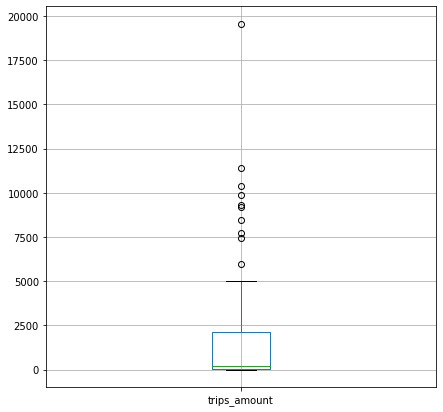

In [15]:
# Supongo que el describe no muestra la distribucion de la mejor forma, asi que veamos con un boxplot
company_trips.boxplot('trips_amount',figsize=(7,7))
plt.show()

Eso muestra mejor la situación, podemos observar como una empresa se ubica muy por encima de la competencia con aproximadamente 8000 viajes mas que la que le sigue. Tambien podemos ver como la mediana se ubica bastante abajo dentro de la caja indicando que la mayoria de las empresas en la tabla no tienen un numero muy alto de viajes. Entonces dejemos de hablar en abstractos y veamos el top 10.

In [16]:
# Vamos a aprovechar que la tabla ya esta ordenada en base a trips_amount
company_trips.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


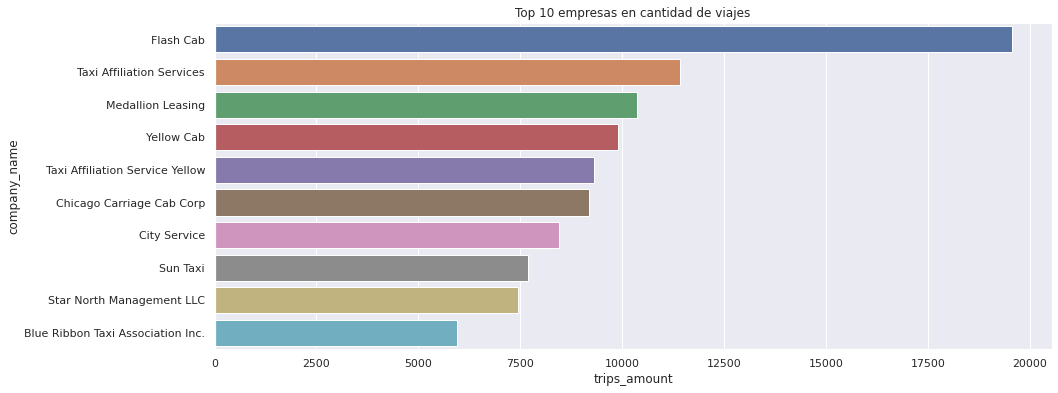

In [17]:
# Ahora vamos a graficar las top 10 empresas
data = company_trips.head(10)

# Determinamos el tamaño de la gráfica
sns.set(rc={'figure.figsize':(15,6)})

# Finalmente graficamos
sns.barplot(data= data, x='trips_amount',y='company_name',orient='h').set(title='Top 10 empresas en cantidad de viajes')
sns.set_style("whitegrid")
plt.show()

Ciertamente podemos notar la amplia diferencia que presenta *Flash Cab* sobre la competencia y tambien podemos notar como *Blue Ribbon Taxi Association Inc.* (la 10° empresa) presenta una diferencia siginificativa respecto a la 2° empresa, con casi la mitad de viajes.
  
Podemos entonces notar como el comportamiento observado en los graficos de cajas y el describe se ve mucho más explícito en ésta gráfica.
  
Ahora vamos a pasar a analizar los barrios más comúnes en los que se suelen dejar los clientes de Chicago. 

In [18]:
# Vamos a seguir el mismo MO y ver el describe primero
neighborhood_trips['average_trips'].describe().reset_index()

,index,average_trips
0,count,94.000000
1,mean,599.953728
2,std,1714.591098
3,min,1.800000
4,25%,14.266667
5,50%,52.016667
6,75%,298.858333
7,max,10727.466667


Al parecer nos encontramos con una situación similar a las empresas en la que unos barrios son mucho más populares que el resto causando que el promedio se encuentre muy por encima de la mediana y la varianza se ubique por encima del promedio. Veamos en más detalle esos fenómenos.

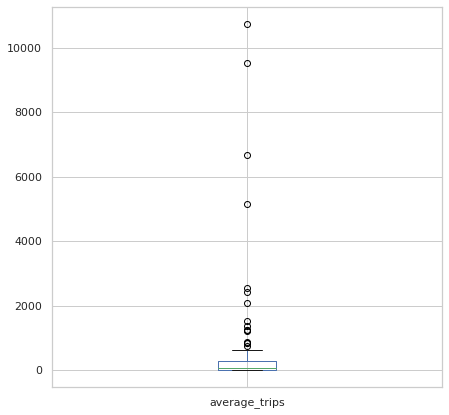

In [19]:
# Un boxplot igual que antes
neighborhood_trips['average_trips'].plot.box(figsize=(7,7))
plt.show()

Efectivamente vemos una situación más polarizada que en la tabla anterior. Entremos mas en detalle entonces!

In [20]:
# Veamos los numeros de los top 10 barrios
neighborhood_trips.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


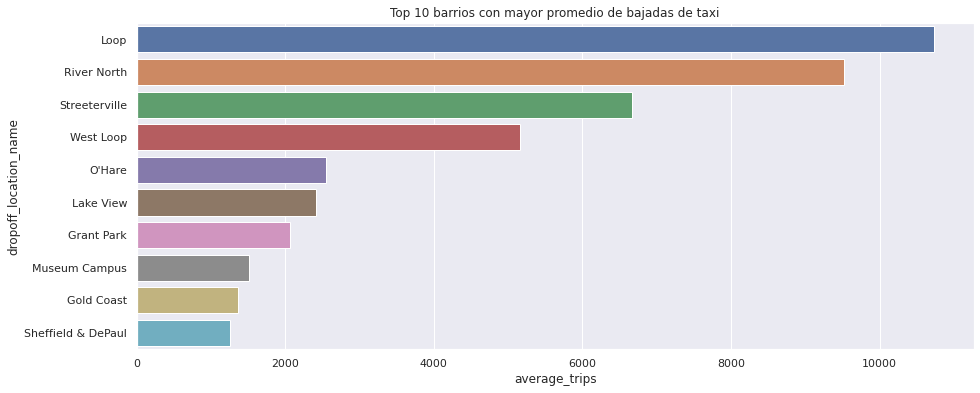

In [21]:
# Ahora vamos a graficar los top 10 barrios
data = neighborhood_trips.head(10)

# Determinamos el tamaño de la gráfica
sns.set(rc={'figure.figsize':(15,6)})

# Finalmente graficamos
sns.barplot(data= data, x='average_trips',y='dropoff_location_name',orient='h').set(title='Top 10 barrios con mayor promedio de bajadas de taxi')
sns.set_style("whitegrid")
plt.show()

Bueno, admito que mi busqueda es Wikipedia, pero lo que encontramos sobre las 4 primeras ciudades es:
- **El Loop** es el segundo distrito comercial más grande de Norteamérica, alberga el Ayuntamiento de Chicago, la sede del condado de Cook y numerosas oficinas de otros niveles de gobierno y consulados de naciones extranjeras.
- **River North o River North Gallery District**, en su momento albergó la mayor concentración de galerías de arte de Estados Unidos fuera de Manhattan.
- **Streeterville** limita al sur con el río, al oeste con el tramo de la Magnificent Mile de la avenida Michigan y al norte y al este con el lago Michigan
- **El West Loop** se extiende a lo largo de la orilla oeste del río Chicago. Antigua zona de fabricación y almacenamiento, muchos de los edificios se han reconvertido en lofts, restaurantes, bares y galerías de arte.
  
Elegimos esas 4 ya que se levantan muy por encima en nuestro top 10! Y ciertamente es entendible su posición tras leer un poco sobre que tienen esos barrios... no tienen páginas de Wikipedia particularmente... cortas.

# <a id='toc7_'></a>[Prueba de hipótesis](#toc0_)
  
El EDA se sintió un poco corto, pero es natural ya que tenemos con las 2 tablas 4 columnas totales de las cuales solo 2 son numéricas, lo que causa que dicha etapa sea naturalmente corta. De todas formas logramos obtener conclusiones muy interesantes al respecto y no tengo dudas que de requerirlo, se podria indagar mucho más en las tablas.
  
Con el EDA terminado, podemos proceder a nuestra prueba de hipótesis. Para ella vamos a trabajar con una tabla diferente a las anteriores que contiene datos sobre viajes desde el Loop hasta el Aeropuerto Internacional O'Hare. Las columans de la tabla son:
  
- **start_ts**: fecha y hora de la recogida
- **weather_conditions**: condiciones climáticas en el momento en el que comenzó el viaje
- **duration_seconds**: duración del viaje en segundos
  
Y la hipótesis que vamos a poner a prueba es:
  
*"La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos".*
  
Antes de decidir los parámetros de la prueba vamos a evaluar bien los datos.

In [22]:
# Primero cargamos los datos
weather_trips = pd.read_csv('/datasets/project_sql_result_07.csv')

In [23]:
# Ahora le damos un vistazo a la tabla
weather_trips.info()
weather_trips

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


In [24]:
# Lo primero que me llama la atención es ese 0 en la fila 1063, veamos si esta solo
weather_trips.loc[weather_trips.duration_seconds == 0]

,start_ts,weather_conditions,duration_seconds
163,2017-11-11 09:00:00,Good,0.0
168,2017-11-11 07:00:00,Good,0.0
204,2017-11-18 19:00:00,Good,0.0
552,2017-11-04 01:00:00,Good,0.0
801,2017-11-04 09:00:00,Good,0.0
1063,2017-11-25 11:00:00,Good,0.0


Vemos que tenemos 6 viajes que tienen una duración de 0 segundos, eso puede ser por que el viaje haya sido cancelado o quizas corresponden a una misma empresa que cargó mal esos viajes. De cualquier manera, dado que representan aproximadamente un 0.6% de los datos me parece mas prudente eliminarlos para que no modifiquen el promedio de la categoría *Good*.

In [25]:
# Vamos a eliminar las filas manualmente ya que son 6 nada mas
weather_trips.drop(index=[163,168,204,552,801,1063],inplace=True)

In [26]:
# Verificamos que se haya hecho efectivo el cambio
weather_trips.loc[weather_trips.duration_seconds == 0]

,start_ts,weather_conditions,duration_seconds


In [27]:
# Con esos valores fuera de la mesa, podemos obtener 2 tablas segun el weather
good_weather = weather_trips.loc[weather_trips.weather_conditions == 'Good']
bad_weather = weather_trips.loc[weather_trips.weather_conditions == 'Bad']

In [28]:
# Veamos cuantas filas tiene good_weather
good_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882 entries, 0 to 1066
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            882 non-null    object 
 1   weather_conditions  882 non-null    object 
 2   duration_seconds    882 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.6+ KB


Ahora vamos a filtrar los *outliers* de éstos datos. Para eso veamos de crear una pequeña funcion que nos ahorrará mucho tiempo.
Basaremos esta funcion en el z-value respecto a una distribucion estandar.

In [48]:
def remove_outliers(df,column:str): # Como podemos ver, debemos entregar el DataFrame y la columna a modificar
    
    # Primero determinamos la media y la desv. estandar
    mean =  df[column].mean()
    std = df[column].std()
    
    # Despues determinamos el z-score aprovechando la vectorizacion
    z_scores = ((df[column] - mean)/std).abs()
    
    # De ahi, si queremos eliminar los outliers nos quedamos solo con los menores e iguales a 3
    inliers_map = z_scores<=3
    
    # Finalmente filtramos el df con el mapa que tenemos
    inliers_df = df[inliers_map]
    
    # Y devolvemos el nuevo df [Nota: hay que reemplazar manualmente, no es inplace]
    return inliers_df

In [49]:
# Probamos la funcion
remove_outliers(good_weather,'duration_seconds')

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1060,2017-11-04 14:00:00,Good,2700.0
1062,2017-11-11 06:00:00,Good,1500.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0


Vemos que devuelve un df de 877 filas, por lo tanto vemos como 5 filas fueron eliminadas. Ya que no perdimos tantos, podemos proceguir con confianza y borrar definitivamente esos outliers!

In [50]:
good_weather = remove_outliers(good_weather,'duration_seconds')

In [51]:
### Y veamos el info de bad weather tambien
bad_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 6 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            180 non-null    object 
 1   weather_conditions  180 non-null    object 
 2   duration_seconds    180 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.6+ KB


In [52]:
remove_outliers(bad_weather,'duration_seconds')

,start_ts,weather_conditions,duration_seconds
6,2017-11-04 16:00:00,Bad,2969.0
30,2017-11-18 12:00:00,Bad,1980.0
34,2017-11-04 17:00:00,Bad,2460.0
51,2017-11-04 16:00:00,Bad,2760.0
52,2017-11-18 12:00:00,Bad,2460.0
...,...,...,...
1031,2017-11-18 12:00:00,Bad,2560.0
1032,2017-11-18 10:00:00,Bad,1908.0
1053,2017-11-18 12:00:00,Bad,2400.0
1061,2017-11-18 16:00:00,Bad,2186.0


In [53]:
# Y aca vemos solo 1 eliminada, sigamos tranquilos
bad_weather = remove_outliers(bad_weather,'duration_seconds')

Al parecer Chicago experimentó muchos más sábados con buen clima que con mal clima, pero para nuestra suerte tenemos suficientes filas en `bad_weather` como para realizar pruebas de hipótesis con confianaza.
  
Dado que estamos tratando con dos conjuntos de datos podemos utilizar entonces la funcion `ttest_ind` aunque antes tendríamos que verificar si los conjuntos poseen varianzas estadisticamente iguales o no.
  
Vamos entonces a definir la hipótesis nula y la alternativa:
- *H0: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare no cambia los sábados lluviosos.*
- *H1: La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos.*
  
Lo ultimo que nos queda definir es el factor de significancia *alpha*, el cual vamos a determinar como el estándar del 5%. 

In [54]:
# Primero vamos a guardar en dos variables los grupos que vamos a estar comparando
good_weather_data = good_weather['duration_seconds']
bad_weather_data = bad_weather['duration_seconds']

In [55]:
# De ahi vamos a realiar una prueba de Levene para determinar si las varianzas de los dos grupos son iguales o no
# Primero definimos el factor de significancia
alpha = 0.05

# Realizamos la prueba de Levene y la guardamos
results = st.levene(good_weather_data,bad_weather_data)

# Finalmente imprimimos el pvalue y el resultado de la prueba
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Las varianzas son estadisticamente diferentes')
else:
    print("No podemos afirmar que las varianzas son estadisticamente diferentes")

p-value:  0.7888178851804917
No podemos afirmar que las varianzas son estadisticamente diferentes


In [56]:
# Con la prueba terminada y las varianzas determinadas como similares, vamos a proceder a evaluar las hipotesis
# Tomamos el alfa que dijimos previamente
alpha = 0.05

# Como sabemos que las varianzas no son diferentes en cada grupo, establecemos el parámetro equal_var como True
results = st.ttest_ind(good_weather_data, bad_weather_data, equal_var=True)

# Finalmente vemos la respuesta que tanto buscamos
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print('Rechazamos la hipótesis nula')
else:
    print("No rechazamos la hipótesis nula")

p-value:  2.3968233040077725e-13
Rechazamos la hipótesis nula


Whoa! A ver como se ve en notación normal: **0.00000000000013**
  
Ciertamente vemos un valor extremadamente bajo! Eso nos indica de que la posibilidad de que los promedios sean iguales es extremadamente bajos por lo que todo indica que la hipótesis a probar es cierta. Con un valor tan bajo hasta se podria decir que una ttest era demasido, pero me gusta matar hormigas con bazookas. Un detalle no menor es que por mas que sea tentador, no podemos afirmar si los días lluviosos suben o bajan el promedio de viaje. Y estrictamente tampoco podemos generalizar ésta conclusión ni a otros barrios ni a otros dias.

# <a id='toc8_'></a>[Conclusión](#toc0_)
  
Finalmente llegamos a la última etapa de nuestro trabajo! Vamos a ir por partes:
1. Al comienzo nos centramos más en la plataforma de consultas del servidor que funciona con PostgreSQL y con un poco de ingenio logramos obtener las 3 tablas con las que trabajamos en éste notebook.
  
2. Con las tablas obtenidas empezamos a revisar unos detalles básicos como la presencia de nulos, duplicados, etc. En éste caso lo máximo que encontramos fueron unos números al comienzo de los nombres de las compañias en la tabla `company_trips` los cuales solucionamos rápidamente con una regex. Aparte de ese detalle, los datos se encontraban en muy buen estado sin ningún error notorio para reportar.
  
3. Posteriormente nos sumergimos en la EDA en donde encontramos no solo las empresas con la mayor cantidad de viajes sino también los barrios en los que más se suelen dejar los clientes.
    - Barrios: Encontramos que los primeros 4 barrios presentaban unos promedio muy por encima del resto siendo que el 4to puesto (West Loop) duplicaba el promedio del 5to puesto (O'Hare), mientras que entre el top 4 la máxima diferencia para dos barrios aledaños (dentro del top) es de un 50% aproximadamente (StreeterVille y River North).
    - Compañias: Las compañias fue una situación similar pero con diferencias claves. Es más que evidente que la empresa *Flash Cab* domina el mercado de los taxis en Chicago, pero no de la misma forma ni presencia que la que vemos en el top 4 de los barrios. Creo que un ejemplo puede ayudar a entender: Si nosotros queremos igualar o superar la cantidad de viajes de *Flash Cab* solo necesitamos 2 o 3 del top 10 empresas para eso. Mientras que si nosotros queremos igualar al *West Loop* (4° puesto) necesitamos 2 pero si queremos igualar a *Streeterville* son 3 y si hablamos de *Loop* necesitamos posiblemente mas de 10.

  
4. Despues de eso pasamos a nuestra prueba de hipótesis en la que eliminamos una mísera cantidad de valores cuyo tiempo registrado era 0. Tras evaluar si podiamos considerar las varianzas de los datos diferentes o no pasamos a realizar la prueba de hipótesis tomando el factor de significancia como 0.05 (o 5%). Al realizar la prueba nos encontramos con un p-value absurdamente bajo, de tal forma que aún si usaramos un alfa que nos garantice 1 falso positivo cada **100.000.000.000** de pruebas la conclusión sería la misma. Incluso se me cruza por la mente si convenía eso o ver las varianzas y promedios lado a lado... mejor hacer pruebas.